In [1]:
from fastai.tabular import *
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sample = pd.read_csv("/content/sample_submission.csv")

In [3]:
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [4]:
df.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

In [5]:
df.isnull().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [6]:
df.dropna(axis = 0,inplace=True)

In [7]:
df.drop("Employee ID",axis=1,inplace=True)
test.drop("Employee ID",axis=1,inplace=True)
df.drop_duplicates(inplace=True)

In [8]:
df = add_datepart(df, 'Date of Joining')

/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


In [9]:
df.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Date of JoiningYear,Date of JoiningMonth,Date of JoiningWeek,Date of JoiningDay,Date of JoiningDayofweek,Date of JoiningDayofyear,Date of JoiningIs_month_end,Date of JoiningIs_month_start,Date of JoiningIs_quarter_end,Date of JoiningIs_quarter_start,Date of JoiningIs_year_end,Date of JoiningIs_year_start,Date of JoiningElapsed
0,Female,Service,No,2.0,3.0,3.8,0.16,2008,9,40,30,1,274,True,False,True,False,False,False,1222732800
1,Male,Service,Yes,1.0,2.0,5.0,0.36,2008,11,48,30,6,335,True,False,False,False,False,False,1228003200
3,Male,Service,Yes,1.0,1.0,2.6,0.20,2008,11,45,3,0,308,False,False,False,False,False,False,1225670400
4,Female,Service,No,3.0,7.0,6.9,0.52,2008,7,30,24,3,206,False,False,False,False,False,False,1216857600
5,Male,Product,Yes,2.0,4.0,3.6,0.29,2008,11,48,26,2,331,False,False,False,False,False,False,1227657600


In [10]:
df.shape

(18584, 20)

In [11]:
dep_var ='Burn Rate'

In [12]:
test = add_datepart(test, 'Date of Joining')

/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


In [13]:
procs = [Categorify,Normalize]

In [14]:
cont,cat = cont_cat_split(df, 1, dep_var='Burn Rate')

In [15]:
cont_t,cat_t = cont_cat_split(test, 1)

In [16]:
path = " "
start_indx = len(df) - int(len(df) * 0.2)

#End index for creating a validation set from train_data
end_indx = len(df)
#TabularList for Validation
val = (TabularList.from_df(df.iloc[start_indx:end_indx].copy(),
                           path= path,cat_names=cat,
                           cont_names = cont))
test = (TabularList.from_df(test, path=path, cat_names=cat_t, cont_names=cont_t, procs=procs))

In [17]:
data = (TabularList.from_df(
    df,path=path,cat_names=cat, 
    cont_names=cont, 
    procs=procs).split_by_idx(list(range(start_indx,end_indx)))
    .label_from_df(cols=dep_var)
    .add_test(test)
    .databunch())

In [18]:
data.show_batch(rows=5)

Gender,Company Type,WFH Setup Available,Date of JoiningYear,Date of JoiningIs_month_end,Date of JoiningIs_month_start,Date of JoiningIs_quarter_end,Date of JoiningIs_quarter_start,Date of JoiningIs_year_end,Date of JoiningIs_year_start,Designation,Resource Allocation,Mental Fatigue Score,Date of JoiningMonth,Date of JoiningWeek,Date of JoiningDay,Date of JoiningDayofweek,Date of JoiningDayofyear,Date of JoiningElapsed,target
Female,Service,Yes,2008,False,False,False,False,False,False,-1.0397,-0.7257,0.0888,-0.7288,-0.8227,-1.3448,0.5137,-0.8382,-0.8382,0.42
Female,Service,Yes,2008,False,False,False,False,False,False,-0.1584,-0.7257,-0.4828,-0.1477,-0.1584,-0.7753,-1.4827,-0.2123,-0.2123,0.37
Male,Product,No,2008,False,False,False,False,False,False,1.6040,1.2259,1.2321,-0.4382,-0.4242,-0.2059,-0.4845,-0.4589,-0.4589,0.69
Male,Service,Yes,2008,False,False,False,False,False,False,-1.0397,-1.2136,-1.8340,1.5956,1.7015,1.3884,1.5119,1.7034,1.7034,0.14
Male,Service,Yes,2008,False,False,False,False,False,False,-0.1584,-0.7257,-1.0025,0.4334,0.5058,0.8190,1.0128,0.4990,0.4990,0.28


In [19]:
#Initializing the network
learn = tabular_learner(data, layers=[1000,800,500,400,300,200, 100, 50], metrics= [r2_score])

In [20]:
learn.summary

<bound method model_summary of Learner(data=TabularDataBunch;

Train: LabelList (14868 items)
x: TabularList
Gender Female; Company Type Service; WFH Setup Available No; Date of JoiningYear 2008; Date of JoiningIs_month_end True; Date of JoiningIs_month_start False; Date of JoiningIs_quarter_end True; Date of JoiningIs_quarter_start False; Date of JoiningIs_year_end False; Date of JoiningIs_year_start False; Designation -0.1584; Resource Allocation -0.7257; Mental Fatigue Score -1.0025; Date of JoiningMonth 0.7240; Date of JoiningWeek 0.9044; Date of JoiningDay 1.6162; Date of JoiningDayofweek -0.9836; Date of JoiningDayofyear 0.8594; Date of JoiningElapsed 0.8594; ,Gender Male; Company Type Service; WFH Setup Available Yes; Date of JoiningYear 2008; Date of JoiningIs_month_end True; Date of JoiningIs_month_start False; Date of JoiningIs_quarter_end False; Date of JoiningIs_quarter_start False; Date of JoiningIs_year_end False; Date of JoiningIs_year_start False; Designation -1.0397; R

epoch,train_loss,valid_loss,r2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


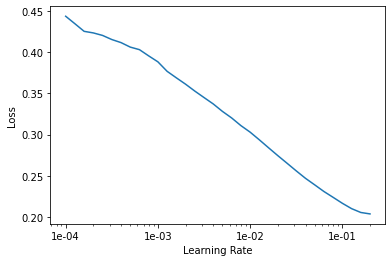

In [21]:
learn.lr_find(start_lr = 1e-05,end_lr = 1e+05, num_it = 100)
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(10,1e-02)

epoch,train_loss,valid_loss,r2_score,time
0,0.016193,0.006517,0.813372,00:04
1,0.006905,0.003976,0.888962,00:04
2,0.006971,0.007130,0.803265,00:04
3,0.005889,0.007472,0.791238,00:04
4,0.005593,0.004331,0.878107,00:04
5,0.004682,0.003211,0.910188,00:04
6,0.004490,0.003430,0.905355,00:04
7,0.004396,0.004234,0.882843,00:04
8,0.003963,0.003119,0.914343,00:04
9,0.003875,0.003012,0.917567,00:04


epoch,train_loss,valid_loss,r2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


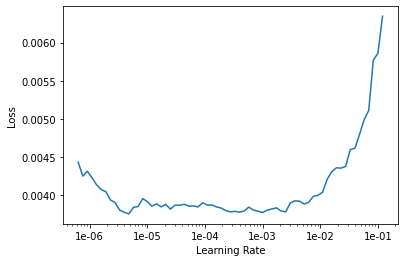

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(10, 1e-05)

epoch,train_loss,valid_loss,r2_score,time
0,0.003855,0.003076,0.915369,00:04
1,0.003918,0.002934,0.919127,00:04
2,0.004009,0.002998,0.917179,00:04
3,0.003740,0.003011,0.917536,00:04
4,0.003842,0.002989,0.917564,00:04
5,0.003907,0.002941,0.919166,00:04
6,0.003723,0.002959,0.918900,00:04
7,0.003890,0.003078,0.915462,00:04
8,0.003914,0.003045,0.916341,00:04
9,0.003755,0.003174,0.913102,00:04


In [25]:
learn.show_results(ds_type=DatasetType.Valid)

Gender,Company Type,WFH Setup Available,Date of JoiningYear,Date of JoiningIs_month_end,Date of JoiningIs_month_start,Date of JoiningIs_quarter_end,Date of JoiningIs_quarter_start,Date of JoiningIs_year_end,Date of JoiningIs_year_start,Designation,Resource Allocation,Mental Fatigue Score,Date of JoiningMonth,Date of JoiningWeek,Date of JoiningDay,Date of JoiningDayofweek,Date of JoiningDayofyear,Date of JoiningElapsed,target,prediction
Female,Service,Yes,2008,False,False,False,False,False,False,0.7228,0.2501,-0.1191,-1.0193,-1.0220,-0.6615,-1.4827,-1.0753,-1.0753,0.38,[0.429974]
Male,Service,Yes,2008,False,False,False,False,False,False,-1.0397,-1.2136,-1.2104,-1.3098,-1.2877,-0.5476,-1.4827,-1.3409,-1.3409,0.24,[0.238126]
Female,Service,Yes,2008,False,False,False,False,False,False,-1.9209,-1.7015,-2.8214,0.7240,0.7051,-0.6615,-0.4845,0.6697,0.6697,0.04,[0.058021]
Female,Service,Yes,2008,False,False,False,False,False,False,0.7228,0.7380,0.5046,0.7240,0.7715,-0.0920,-1.4827,0.7171,0.7171,0.44,[0.55032]
Male,Product,No,2008,False,False,False,False,False,False,-0.1584,0.7380,0.3487,1.0145,1.0373,0.1357,0.5137,1.0206,1.0206,0.6,[0.552395]


In [26]:
test = pd.read_csv("/content/test.csv")
submit = pd.DataFrame()
submit['Employee ID'] = test['Employee ID']

In [27]:
test_predictions = learn.get_preds(ds_type=DatasetType.Test)[0]

In [28]:
test_predictions = [i[0] for i in test_predictions.tolist()]

In [29]:
submit['Burn Rate'] = test_predictions

In [30]:
submit.head()

,Employee ID,Burn Rate
0,fffe31003300390039003000,0.603946
1,fffe31003300310037003800,0.352708
2,fffe33003400380035003900,0.427724
3,fffe3100370039003200,0.386192
4,fffe32003600390036003700,0.513574


In [31]:
submit.to_csv('submit.csv',index=False)